In [1]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import pickle
import simulations.serology as serology
import pandas as pd
from scipy.io import mmread
import osgeo.gdal as gdal
import os

In [2]:
# Import the trac data
tracdata = pd.read_csv('../trac_data/summary_TRaC_data_with_covariates.csv')
tracdata[tracdata.Age < 51]

# Village positions
village_lats = tracdata.groupby(['Cluster_Num'])['Latitude'].unique().values
village_longs = tracdata.groupby(['Cluster_Num'])['Longitude'].unique().values

# Number of villages
Nvillages = tracdata.Cluster_Num.unique().size

# Extract the titres and ages for all individuals, grouped by village
titres = np.log(abs(tracdata.MSP.values+30))
ages = tracdata.Age.values
cluster_assignments = tracdata.Cluster_Num.values

# Number of individuals
Nindividuals = len(tracdata.Age.values)

# Extract the mean covariates in each cell
covariates = tracdata.groupby(['Cluster_Num'])['covariate_accessibility','covariate_AI','covariate_distTowater','covariate_elevation','covariate_forest','covariate_grass','covariate_urbanbarren','covariate_woodysavanna','covariate_OSM','covariate_PET','covariate_slope','covariate_TWI'].mean().values

# Number of covariates
Ncovariates = covariates.shape[1]

# Matrix to project linear predictor into values for individuals at their cluster assignments
Pmatrix = np.zeros((Nindividuals, Nvillages))
for i in range(Nindividuals):
    Pmatrix[i,cluster_assignments[i]-1] = 1

In [3]:
# Read in matrices for INLA mesh projections

# Projection from INLA grid to cluster locations
Amatrix = mmread('data/A_matrix.mtx')

# Size of INLA grid
Nmesh = Amatrix.shape[1]

# The various bits of the SPDE precision matrix (on the INLA grid)
M0 = mmread('data/M0_matrix.mtx')
M1 = mmread('data/M1_matrix.mtx')
M2 = mmread('data/M2_matrix.mtx')

# Cast to tf constants
Amatrix = Amatrix.toarray() # Not sure if it's worth figuring out how to use SparseTensors
M0 = M0.toarray()
M1 = M1.toarray()
M2 = M2.toarray()

# Matrix to project INLA triangular grid to the full resolution of the covariates
Afullmatrix = mmread('data/Afull_matrix.mtx')
Afullmatrix = Afullmatrix.toarray()

In [4]:
model = """
    
data {

    // Serology data
    int n_individuals; // number of individuals in dataset
    vector[n_individuals] ages; // ages of the individuals in the dataset
    vector[n_individuals] titres; // (transformed) titres
    int n_serology; // number of serology parameters
    int n_parameters;// = n_serology + 2 (serology parameters + log_eir + age)
    
    // Neural network parameters
    int n_layers; // number of layers in the MDN
    int n_hiddens; // number of units per hidden layer
    int n_components; // number of MDN components
    int n_output;// = 3*n_components (size of the output layer of the network)
    
    // Neural network weights and biases
    matrix[n_parameters,n_hiddens] W0; // weights of the initial layer of the network
    matrix[n_hiddens,n_output] Wn; // final layer weights
    row_vector[n_hiddens] b0; // biases of the network first layer
    row_vector[n_output] bn; // biases of the network final layer

    // Batch normalizations
    real x_mean;
    real x_std;
    row_vector[n_parameters] p_mean;
    row_vector[n_parameters] p_std;
    
    // Matrices for GP covariance on INLA grid
    int n_mesh;
    int n_locations;
    matrix[n_locations, n_mesh] Amatrix;
    matrix[n_mesh, n_mesh] M0;
    matrix[n_mesh, n_mesh] M1;
    matrix[n_mesh, n_mesh] M2;
    
    // Covariates
    int n_covariates;
    matrix[n_locations, n_covariates] covariates;
    
    // Matrix to expand linear predictor into values for each individual
    matrix[n_individuals, n_locations] Pmatrix; // cluster assignments for each individual in matrix form
}
    
parameters {
    
    // Serology parameters
    row_vector[n_serology] serology;
    
    // Gaussian process hyper-parameters
    real log_kappa;
    real log_tau;
    
    // Intercept and slopes wrt linear covariates
    real intercept;
    vector[n_covariates] slopes;
    
    // Field
    vector[n_mesh] log_field;
}
    
model {

    // Declarations...

    // Mixture model component contributions to likelihood for each individual
    vector[n_components] components;
    
    // MDN mixture components
    row_vector[n_components] mu[n_individuals]; 
    row_vector[n_components] s[n_individuals];
    row_vector[n_components] log_r[n_individuals];
    
    // MDN input/output layers
    row_vector[n_parameters] input_layers[n_individuals];
    row_vector[n_output] output_layers[n_individuals];
    
    // GP precision (on INLA grid)
    matrix[n_mesh, n_mesh] spde_prec;
    
    // Linear predictor and values for each individual
    vector[n_locations] linear_predictor;
    vector[n_individuals] linear_predictor_individuals;
    
    // Computed quantities...
    
    // GP precision (on INLA grid)
    spde_prec = (exp(log_kappa*4.0)*M0 + 2.0*exp(log_kappa*2.0)*M1 + M2)*exp(log_tau*2.0);
    
    // Linear predictor and value for individuals
    linear_predictor = (Amatrix*log_field) + (covariates*slopes) + intercept*rep_vector(1, n_locations);
    linear_predictor_individuals = Pmatrix*linear_predictor;
    
    // Construct MDN outputs/mixture model parameters
    for(i in 1:n_individuals){
    
        // Input layer: [log_eir, serology params, age]
        input_layers[i][1] = linear_predictor_individuals[i];
        input_layers[i][2:n_serology+1] = serology;
        input_layers[i][n_serology+2] = ages[i];
        
        // Normalize the input layer
        input_layers[i] = (input_layers[i] - p_mean)./p_std;
        
        // Output layer
        output_layers[i] = tanh(input_layers[i]*W0 + b0)*Wn + bn;
        
        // Get the MDN mixture component from the output layer
        mu[i] = output_layers[i][1:n_components];
        s[i] = exp(output_layers[i][n_components+1:2*n_components+1]);
        log_r[i] = log(exp(output_layers[i][2*n_components+1:3*n_components])/sum(exp(output_layers[i][2*n_components+1:3*n_components])));
    }
    
    // Priors...
    
    // Priors on serology parameters
    serology[1] ~ uniform(0, 1); // fzero
    serology[2] ~ uniform(0, 1); // gzero
    serology[3] ~ uniform(5, 35); // azero
    serology[4] ~ uniform(log(0.05), log(4)); // logHetBoosting
    serology[5] ~ uniform(log(10), log(30000)); // logBaselineBoostingFactor
    serology[6] ~ uniform(log(10), log(10000)); // logBaselineBoostingThreshold
    serology[7] ~ uniform(log(0.05), log(4)); // logAttenuationFactor
    serology[8] ~ uniform(2, 20); // NAdultAntibodies
    serology[9] ~ uniform(log(0.01), log(10)); // logRhoChild
    serology[10] ~ uniform(log(0.01), log(20)); // logRhoAdultExtra
    serology[11] ~ uniform(log(0.25), log(1)); // logHet
    serology[12] ~ uniform(0, 10); // mu0
    serology[13] ~ uniform(log(1), log(5)); // log_sd
    
    // Priors on GP parameters
    log_kappa ~ normal(0, 1);
    log_tau ~ normal(0, 2);
    
    // GP prior on the field
    log_field ~ multi_normal_prec(rep_vector(0, n_mesh), spde_prec);
    
    // Likelihood...
        
    // Construct target density
    for(i in 1:n_individuals){
        for(c in 1:n_components){
            components[c] = normal_lpdf((titres[i] - x_mean)/x_std | mu[i][c], 1./s[i][c]) + log_r[i][c];
        }
        target += log_sum_exp(components);
    }
}
    
"""

In [5]:
# Compile the model
MODEL = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2fe673b5f9729eea68bb73a81579cbf NOW.
/usr/local/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/zy/hj602m6n0w19_z63287bdt5w0000gn/T/tmp6l8rjtjl/stanfit4anon_model_e2fe673b5f9729eea68bb73a81579cbf_8484473045039558224.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [27]:
# Import weights and biases and batch norms
weights = pickle.load(open('simulations/simulations/model_2/network_weights.pkl', 'rb'))
biases = pickle.load(open('simulations/simulations/model_2/network_biases.pkl', 'rb'))
x_mean, x_std, p_mean, p_std = pickle.load(open('simulations/simulations/model_2/batch_normalizations.pkl', 'rb'))

# Import initializations for field etc
log_field_init, slopes_init, intercept_init, log_kappa_init, log_tau_init = pickle.load(open('initialization.pkl', 'rb'))

# Initial serology parameter values
serology_init = np.array([0.5, 0.013, 33., np.log(3.), np.log(39.), np.log(9838.), 0.17, 16, np.log(2.9), np.log(14), np.log(0.75), 5, np.log(3)])

In [28]:
input_data = {
    
    # Serology data
    'n_individuals':Nindividuals,
    'ages':ages,
    'titres':titres,
    'n_serology':13,
    'n_parameters':15,
    
    # Neural network parameters
    'n_layers':2,
    'n_hiddens':100,
    'n_components':8,
    'n_output':24,
    
    # Neural network weights and biases
    'W0':weights[0],
    'Wn':weights[-1],
    'b0':biases[0],
    'bn':biases[-1],

    # Batch normalizations
    'x_mean':x_mean[0],
    'x_std':x_std[0],
    'p_mean':p_mean,
    'p_std':p_std,
    
    # GP matrices and INLA grid set-up
    'Amatrix':Amatrix,
    'M0':M0,
    'M1':M1,
    'M2':M2,
    'n_mesh':Nmesh,
    'n_locations':Nvillages,
    
    # Covariates
    'n_covariates':covariates.shape[1],
    'covariates':covariates,
    
    # Cluster assignments
    'Imatrix':Pmatrix
}

initialization = {
    
    'log_field':log_field_init,
    'serology':serology_init,
    'slopes':slopes_init,
    'inercept':intercept_init,
    'log_kappa':log_kappa_init,
    'log_tau':log_tau_init
}

In [ ]:
fit = MODEL.sampling(data=input_data, iter=5000, warmup=2000, chains=1, init=[initialization])

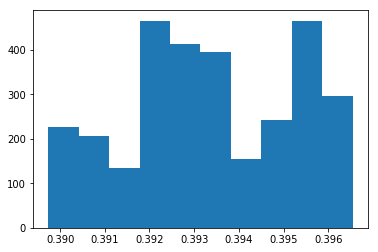

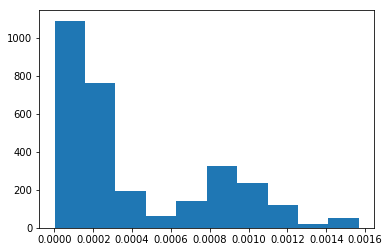

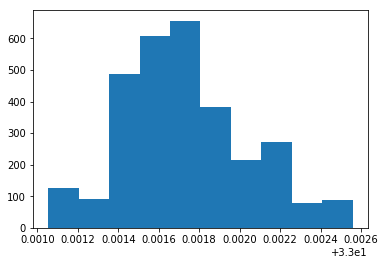

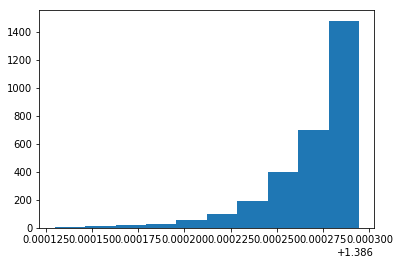

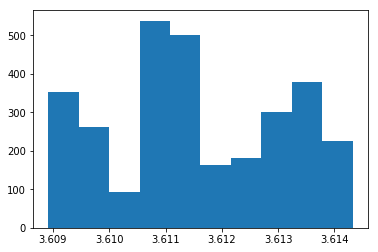

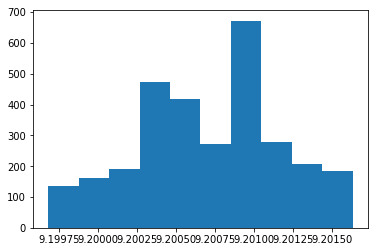

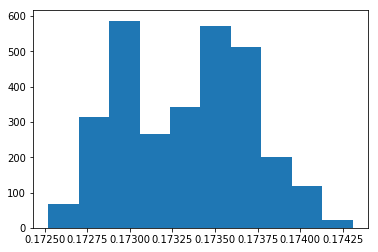

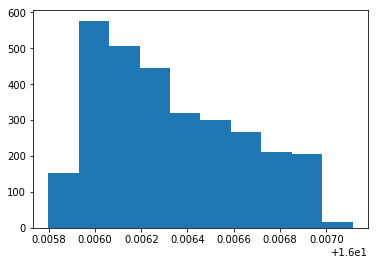

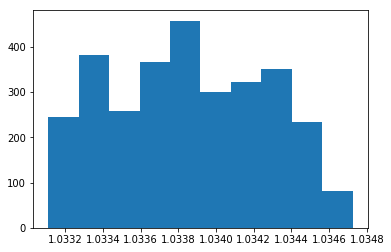

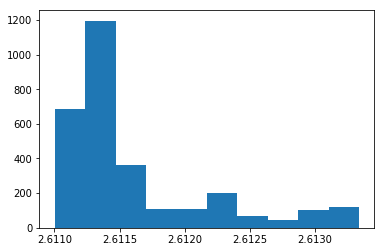

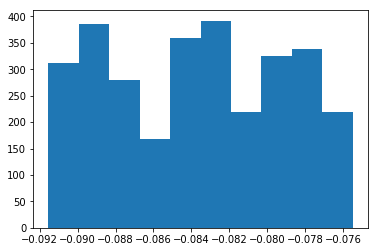

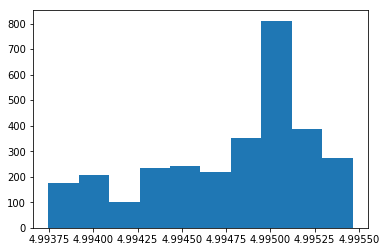

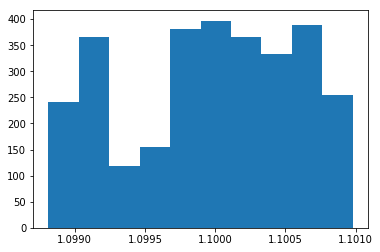

In [26]:
# Plot serology parameter posteriors
for i in range(13):
    plt.hist(fit.extract()['serology'][:,i])
    plt.show()

In [11]:
# Pull out the log-field at the conditional mode with the empirical Bayes hyper-parameters
log_field = np.mean(fit.extract()['log_field'], axis=0)
slopes = np.mean(fit.extract()['slopes'], axis=0)
intercept = np.mean(fit.extract()['intercept'])

# Full resolution covariates
covariatesfull = pd.read_csv('data/fullcovariates.csv').values[:,1:13]

# Evaluate the high-resolution EIR
linear_predictor = np.dot(Afullmatrix,log_field) + np.dot(covariatesfull,slopes) + intercept

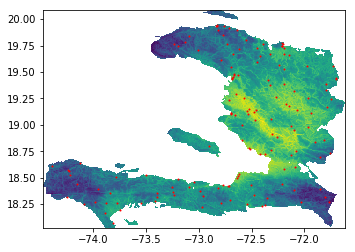

In [22]:
# Plot the recovered EIR map (posterior mean)

# Load in the full resolution covariates tif
ds = gdal.Open('data/covariates_AI.tif')
covariate = ds.GetRasterBand(1)
nodata = covariate.GetNoDataValue()
referenceimage = covariate.ReadAsArray()
referenceimage = np.ma.masked_less(referenceimage,-3)

# Sort out the mask
valid_pixels = referenceimage.mask==0
valid_pixels_indices = np.nonzero(np.ndarray.flatten(valid_pixels)) # row-major flattening
n_valid_pixels = np.sum(valid_pixels)

# Get the lats/longs for the pixel values in the rasters
x0, dx, dxdy, y0, dydx, dy = ds.GetGeoTransform()
nrows, ncols = referenceimage.shape
lonarray = np.linspace(x0, x0+dx*ncols, ncols)
latarray = np.linspace(y0, y0+dy*nrows, nrows)
pixel_longs, pixel_lats = np.meshgrid(lonarray, latarray)

# Create image with the inferred EIR
referenceimage.put(np.where(np.ndarray.flatten(referenceimage.mask)==0),linear_predictor)

# Plot it!
plt.scatter(village_longs, village_lats, c='red', s = 1) # check image coordinate transforms by comparing raster plot against observation locations 
imgplot = plt.imshow(referenceimage,extent=[np.min(pixel_longs),np.max(pixel_longs),np.min(pixel_lats),np.max(pixel_lats)])
plt.xlim(np.min(pixel_longs[valid_pixels]),np.max(pixel_longs[valid_pixels]))
plt.ylim(np.min(pixel_lats[valid_pixels]),np.max(pixel_lats[valid_pixels]))
plt.show()